In [1]:
#config
from sklearn import set_config
set_config(display = "diagram")

#built in
import os 

#HTML
from IPython.core.display import HTML

#data
import pandas as pd
import numpy as np

#preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, KBinsDiscretizer

#pipeline
from sklearn.pipeline import Pipeline, make_pipeline

#compose
from sklearn.compose import ColumnTransformer, make_column_transformer

#Estimator
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

#model selection
from sklearn.model_selection import train_test_split, GridSearchCV

#metrics
from sklearn.metrics import r2_score,mean_squared_error, SCORERS

#data visualisation
import matplotlib.pyplot as plt
import seaborn as sns


#clone
from sklearn.base import clone

In [2]:
sns_c = sns.color_palette(palette='deep')

In [3]:
for root, dirs, files in os.walk(".", topdown=False):
    print(f"root = {root} \n dirs = {dirs}\n files = {files} \n")

root = ./data/source 
 dirs = []
 files = ['day.csv', '2016_Building_Energy_Benchmarking.csv', 'les-arbres.csv'] 

root = ./data/cleaned 
 dirs = []
 files = ['df_clean.csv', 'df_clean2.csv'] 

root = ./data 
 dirs = ['source', 'cleaned']
 files = ['reg_tree.dot', 'reg_tree.pdf'] 

root = ./.ipynb_checkpoints 
 dirs = []
 files = ['exo2 Linear Model statsmodel-checkpoint.ipynb', 'exo Linear Model statsmodel-checkpoint.ipynb', 'modeles-checkpoint.ipynb', 'Shap-checkpoint.ipynb', 'modele regression - SHAP-checkpoint.ipynb', 'Model selection-checkpoint.ipynb', 'Model final-checkpoint.ipynb', 'Exploration-checkpoint.ipynb', 'TestModel-checkpoint.ipynb'] 

root = ./TP_SVM/data/source 
 dirs = []
 files = ['mushrooms.csv'] 

root = ./TP_SVM/data/cleaned 
 dirs = []
 files = [] 

root = ./TP_SVM/data 
 dirs = ['source', 'cleaned']
 files = ['cleaneddf_cleaned.csv'] 

root = ./TP_SVM/.ipynb_checkpoints 
 dirs = []
 files = ['Implementaton model-checkpoint.ipynb', 'TP SVM-checkpoint.ipynb'] 

r

In [4]:
os.listdir('data/cleaned')

['df_clean.csv', 'df_clean2.csv']

# 1 - Preparation des données

## 1.1 - Chargement et présentation

In [5]:
source = 'data/cleaned/'
nom_fichier = 'df_clean2.csv'
df = pd.read_csv(source+nom_fichier, index_col = 0)

In [7]:
df.shape

(2384, 43)

In [8]:
def stats (df):
    
    lines = df.shape[0]
    d_types = df.dtypes
    counts = df.apply(lambda x :x.count())
    unique = df.apply(lambda x : x.nunique())
    nulls = df.isnull().sum()
    missing_ratio = (nulls / lines )*100
    skew = df.skew(numeric_only = True).round(2)
    kurt = df.kurtosis(numeric_only = True).round(2)
    
    col_name = ['dtypes', 'counts', 'unique','skewness', 'kurtosis', 'null', 'missing_ration']
    temp = pd.concat([d_types, counts, unique, skew, kurt, nulls, missing_ratio], axis=1)
    temp.columns = col_name
    return temp

In [9]:
df.head(5)

,BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,TotalGHGEmissions,GHGEmissionsIntensity,NonResidentialGFA,delta_Site_WM,delta_Source_WM,Delta_Site_Source,Delta_Site_Source_WN,ratio_Site_Source_WN,NaturalGaz_p,Electricity_p
0,NonResidential,Hotel,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,...,249.98,2.83,88434,-2.600006,-6.500000,-100.800003,-104.699997,-1.241993,0.176638,0.546060
1,NonResidential,Hotel,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,...,295.86,2.86,103566,-3.099998,-3.299988,-81.300003,-81.499992,-0.832482,0.613391,0.386609
2,NonResidential,Hotel,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,...,2089.28,2.19,756493,-1.699997,-2.200012,-145.899994,-146.400009,-1.498465,0.020579,0.682307
3,NonResidential,Hotel,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,...,286.43,4.67,61320,-2.500000,-7.800003,-105.399994,-110.699997,-0.977052,0.266567,0.407519
4,NonResidential,Hotel,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,...,505.01,2.88,191454,-3.899994,-4.200012,-96.599991,-96.900009,-0.816344,0.621198,0.378802


In [10]:
stats(df).head()

,dtypes,counts,unique,skewness,kurtosis,null,missing_ration
BuildingType,object,2384,8,NaN,NaN,0,0.0
PrimaryPropertyType,object,2384,24,NaN,NaN,0,0.0
CouncilDistrictCode,int64,2384,7,-0.08,-1.51,0,0.0
Neighborhood,object,2384,19,NaN,NaN,0,0.0
Latitude,float64,2384,2110,0.16,-0.17,0,0.0


### 1.1.1 - Les estimateurs utilisés

### Fonction pour afficher les resultats dans une DF

In [11]:
def score_p(modele, X, y):
    y_pred = modele.predict(X)
    rmse = mean_squared_error(y, y_pred, squared = False).round(2)
    r2 = r2_score(y, y_pred).round(2)
    
    return rmse, r2

In [12]:
def add_result(df, data):
    df = df.copy()
    df = df.append(data,  ignore_index= True)
    return df

In [13]:
#fonction pour calculer le R2 et rmse
def summary( modele, df, X_train, X_test, y_train , y_test, 
            ensembliste = 'non',target ='TotalGHGEmissions',commentaires = ""):

    #recupération nom du modele
    nom_modele = modele[-1].__class__.__name__
    
    #Calcul du rmse et r2
    #train set
    train_rmse = score_p(modele, X_train, y_train)[0]
    train_r2 = score_p(modele, X_train, y_train)[1]
    
    #test set
    test_rmse = score_p(modele, X_test, y_test)[0]
    test_r2 = score_p(modele, X_test, y_test)[1]
    
    #On ajoute les données dans la DataFrame
    
    data = {'Modele' : nom_modele,'Ensembliste':ensembliste,'Target' : target,
               'Train_RMSE': train_rmse,'Test_RMSE' : test_rmse,'Train_R2' : train_r2,
               'Test_R2' : test_r2, 'Commentaires' : commentaires}
    df = add_result(df, data)
    return df

# 1.3 - Construction des Preprocesseurs

In [14]:
num_features = []
num_bin_features = []
cat_features = []
features = num_features + num_bin_features + cat_features 

### 1.3.1 - Scaled poly ohe preprocessor (spo)

In [15]:
def init_spo():
    num_t = Pipeline(steps = [
    ('poly', PolynomialFeatures()),
    ('scale',RobustScaler()),
    ])


    num_bin_t = Pipeline(steps = [
        ('kbd' ,KBinsDiscretizer(n_bins = 2))
    ])

    cat_t = Pipeline(steps = [
        ('ohe', OneHotEncoder(handle_unknown = 'ignore'))
    ])


    spo_preprocessor = ColumnTransformer(transformers =[
        #("passthrough_numeric", "passthrough", ["colonnes"])
        ('nun_t', num_t,num_features),
        #('num_bin_t', num_bin_t, num_bin_features),
        ('cat_t', cat_t, cat_features)
    ], remainder = 'drop', verbose_feature_names_out = False, sparse_threshold = 0)
    return spo_preprocessor

In [16]:
init_spo()

ColumnTransformer(sparse_threshold=0,
                  transformers=[('nun_t',
                                 Pipeline(steps=[('poly', PolynomialFeatures()),
                                                 ('scale', RobustScaler())]),
                                 []),
                                ('cat_t',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 [])],
                  verbose_feature_names_out=False)

### 1.3.3 - scaled ohe preprocessor (so)

In [17]:
def init_so():
    so_preprocessor = ColumnTransformer(
        [ 
            ('num_t',RobustScaler(), num_features),
            #('num_bins_t', KBinsDiscretizer(n_bins = 2), num_bin_features),
            ('cat_t', OneHotEncoder(handle_unknown = 'ignore'),cat_features),        
        ],remainder = 'drop', verbose_feature_names_out = False,sparse_threshold = 0)
    return so_preprocessor

In [18]:
init_so()

ColumnTransformer(sparse_threshold=0,
                  transformers=[('num_t', RobustScaler(), []),
                                ('cat_t',
                                 OneHotEncoder(handle_unknown='ignore'), [])],
                  verbose_feature_names_out=False)

###  1.3.2 - ohe preprocessor (o)

In [19]:
def init_o():  
    o_preprocessor = ColumnTransformer(
        [
            ('passthrough_numeric', 'passthrough', num_features),
            ('cat_t', OneHotEncoder(handle_unknown = 'ignore'),cat_features),
        ], remainder = 'drop', verbose_feature_names_out = False,sparse_threshold = 0,
    )
    return o_preprocessor

In [20]:
init_o()

ColumnTransformer(sparse_threshold=0,
                  transformers=[('passthrough_numeric', 'passthrough', []),
                                ('cat_t',
                                 OneHotEncoder(handle_unknown='ignore'), [])],
                  verbose_feature_names_out=False)

# A - Emission de CO2  - TotalGHGEmissions

## 1.2 - Selection des variables 

### variables cible

In [21]:
target = df['TotalGHGEmissions']

### variables explicatives

In [22]:
num_features = [
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'Electricity_p',
    'NaturalGaz_p',
    'Latitude',
    'Longitude',
    'NonResidentialGFA',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)']

num_bin_features =  ['NumberofBuildings']

cat_features = [
    'PrimaryPropertyType',
    'BuildingType',
    'LargestPropertyUseType']

In [23]:
stats(df[num_features + num_bin_features + cat_features])

,dtypes,counts,unique,skewness,kurtosis,null,missing_ration
LargestPropertyUseTypeGFA,float64,2384,2242,5.58,43.16,0,0.0
SecondLargestPropertyUseTypeGFA,float64,2384,1337,5.35,39.62,0,0.0
ThirdLargestPropertyUseTypeGFA,float64,2384,496,17.07,406.05,0,0.0
Electricity_p,float64,2384,1680,-0.44,-0.98,0,0.0
NaturalGaz_p,float64,2384,1628,0.55,-0.89,0,0.0
Latitude,float64,2384,2110,0.16,-0.17,0,0.0
Longitude,float64,2384,1941,-0.10,0.61,0,0.0
NonResidentialGFA,int64,2384,2240,5.94,46.20,0,0.0
PropertyGFAParking,int64,2384,444,5.74,43.52,0,0.0
PropertyGFABuilding(s),int64,2384,2286,5.59,45.23,0,0.0


### 1.3.4 - Séparation de la base de donnée

In [24]:
#creation d'une colonne pour stratifier la séparation entre le jeu d'entrainement et de test
df['GHGEmissionsIntensity_qt'] = pd.qcut(df['GHGEmissionsIntensity'],3)

In [25]:
df['GHGEmissionsIntensity_qt'].value_counts()

(-0.021, 0.39]    800
(1.167, 34.09]    795
(0.39, 1.167]     789
Name: GHGEmissionsIntensity_qt, dtype: int64

In [26]:
#Séparation des observations entre train et test
X_train, X_test, y_train, y_test = train_test_split(df[num_features + cat_features],df['TotalGHGEmissions'].values ,test_size =0.32, random_state =18,
                                     stratify = df['GHGEmissionsIntensity_qt'])

In [27]:
#Creation de la dataframe Summary
df_summary = pd.DataFrame(columns = ['Modele','Ensembliste','Target','Train_RMSE','Test_RMSE','Train_R2',
            'Test_R2', 'Commentaires'])
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires


# 2 - Les Modeles

## 2.1 - Les modeles simples

### 2.1.1 - DummyRegressor

In [28]:
DummyRegressor().get_params().keys()

dict_keys(['constant', 'quantile', 'strategy'])

In [29]:
dummy_reg = Pipeline(
    [
        ("preprocessor", init_spo()),
        ("regressor", DummyRegressor(strategy="mean"))
    ]
)

In [30]:
dummy_reg_CO2 = dummy_reg.fit(X_train, y_train)

In [31]:
df_summary = summary(dummy_reg_CO2, df_summary,X_train, X_test, y_train, y_test)

In [32]:
y_pred_dummy = dummy_reg.predict(X_test)

### 2.2 - Ridge

In [33]:
ridge_reg = Pipeline(
    [
        ("preprocessor", init_spo()),
        ("regressor", Ridge())
    ]
)

In [34]:
ridge_reg[1].get_params().keys()

dict_keys(['alpha', 'copy_X', 'fit_intercept', 'max_iter', 'normalize', 'positive', 'random_state', 'solver', 'tol'])

In [35]:
ridge_reg_CO2 = clone(ridge_reg).fit(X_train, y_train)

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.61694e-26): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


#### Paramétrage

In [36]:
param_grid = {'regressor__alpha' : [0,1,10,100],
              'preprocessor__nun_t__poly__degree': [1,2,3]
             }
scoring = 'neg_mean_squared_error'
gs = GridSearchCV(
    ridge_reg_CO2, param_grid,
    cv =10,
    scoring = scoring,
    n_jobs =-1,
    return_train_score = True, 
    error_score='raise').fit(X_train, y_train)

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.07358e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


In [37]:
results_col = ['params','rank_test_score','mean_test_score', 'std_test_score','mean_train_score', 'std_train_score' ]
HTML(pd.DataFrame(data = gs.cv_results_, columns = results_col).round(2).sort_values(by = 'rank_test_score').head(5).to_html())

,params,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
6,"{'preprocessor__nun_t__poly__degree': 2, 'regressor__alpha': 10}",1,-123396.14,209146.85,-22309.32,1870.45
5,"{'preprocessor__nun_t__poly__degree': 2, 'regressor__alpha': 1}",2,-142965.70,284093.73,-18176.75,1951.49
7,"{'preprocessor__nun_t__poly__degree': 2, 'regressor__alpha': 100}",3,-146092.97,239195.47,-29314.55,2195.59
1,"{'preprocessor__nun_t__poly__degree': 1, 'regressor__alpha': 1}",4,-235307.31,435452.90,-88458.53,16522.67
2,"{'preprocessor__nun_t__poly__degree': 1, 'regressor__alpha': 10}",5,-238367.25,438382.61,-97555.64,17089.14


In [38]:
ridge_reg_CO2.set_params(**gs.best_params_).fit(X_train, y_train)

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=8.07358e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('nun_t',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'Electricity_p',
                                                   'NaturalGaz_p', 'Latitude',
                                                   'Longitude',
                                                   'NonResidentialGFA',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)']),
                                                 ('cat_t',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PrimaryPropertyType',
                                                   'BuildingType',
                                                   'LargestPropertyUseType'])],
                                   verbose_feature_names_out=False)),
                ('regressor', Ridge(alpha=10))])

In [39]:
df_summary = summary(ridge_reg_CO2,df_summary,X_train, X_test, y_train, y_test)

In [40]:
y_pred_ridge = ridge_reg_CO2.predict(X_test)

### 2.1.2 - LinearRegression

In [41]:
lin_reg = Pipeline(steps=
    [('preprocessor' , init_spo()),
     ('regressor' , LinearRegression())
                       
    ],
)

In [42]:
lin_reg_CO2 = clone(lin_reg).fit(X_train, y_train)
#parametrage
scoring = 'neg_mean_squared_error'
params_grid = {'preprocessor__nun_t__poly__degree' : [1,2],
               'regressor__fit_intercept' : [True, False]}
gs = GridSearchCV(lin_reg_CO2,
                  params_grid,
                  cv = 5,
                  scoring = scoring,
                  n_jobs = -1,
                  return_train_score = True
                 ).fit(X_train, y_train)

print(gs.best_params_)

{'preprocessor__nun_t__poly__degree': 1, 'regressor__fit_intercept': True}


In [43]:
gs.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_preprocessor__nun_t__poly__degree', 'param_regressor__fit_intercept', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [44]:
lin_reg_CO2.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary = summary(lin_reg_CO2,df_summary,X_train, X_test, y_train, y_test)

In [45]:
y_pred_linear = lin_reg_CO2.predict(X_test)

### 2.1.3 - DecisionTreeRegressor

In [46]:
tree_reg = Pipeline(steps = [
        ('preprocessor', init_o()),
        ('regressor', DecisionTreeRegressor()),
    ]
)
tree_reg

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'Electricity_p',
                                                   'NaturalGaz_p', 'Latitude',
                                                   'Longitude',
                                                   'NonResidentialGFA',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)']),
                                                 ('cat_t',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PrimaryPropertyType',
                                                   'BuildingType',
                                                   'LargestPropertyUseType'])],
                                   verbose_feature_names_out=False)),
                ('regressor', DecisionTreeRegressor())])

In [47]:
tree_reg_CO2 = clone(tree_reg)
#parametrage
param_grid = {'regressor__max_depth' : [5,8,15],
              'regressor__min_samples_leaf' : [10, 20,30],
             }
scoring = 'neg_mean_squared_error'
gs = GridSearchCV(tree_reg_CO2, param_grid, cv=10, scoring = scoring,return_train_score = True,
                  verbose =-1, n_jobs =-1).fit(X_train, y_train)
print(gs.best_params_)

{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 10}


In [48]:
results = gs.cv_results_
col = ['params','rank_test_score','mean_test_score', 'std_test_score','mean_train_score', 'std_train_score' ]
HTML(pd.DataFrame(results, columns = col).round(2).sort_values(by='rank_test_score').to_html())

,params,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
3,"{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 10}",1,-258187.38,436219.75,-174718.67,58065.07
6,"{'regressor__max_depth': 15, 'regressor__min_samples_leaf': 10}",2,-258520.75,436205.65,-174128.30,57897.97
0,"{'regressor__max_depth': 5, 'regressor__min_samples_leaf': 10}",3,-260681.69,436494.15,-177291.72,58680.68
5,"{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 30}",4,-300188.31,590009.10,-258338.32,62754.58
8,"{'regressor__max_depth': 15, 'regressor__min_samples_leaf': 30}",5,-300202.38,590003.74,-258321.21,62753.19
2,"{'regressor__max_depth': 5, 'regressor__min_samples_leaf': 30}",6,-300274.75,590194.49,-259012.40,62718.11
4,"{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 20}",7,-305069.61,592573.17,-255438.79,62788.85
7,"{'regressor__max_depth': 15, 'regressor__min_samples_leaf': 20}",8,-305114.32,592583.19,-255351.99,62770.48
1,"{'regressor__max_depth': 5, 'regressor__min_samples_leaf': 20}",9,-305147.53,592913.78,-256431.67,62698.62


In [49]:
tree_reg_CO2.set_params(**gs.best_params_).fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'Electricity_p',
                                                   'NaturalGaz_p', 'Latitude',
                                                   'Longitude',
                                                   'NonResidentialGFA',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)']),
                                                 ('cat_t',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['PrimaryPropertyType',
                                                   'BuildingType',
                                                   'LargestPropertyUseType'])],
                                   verbose_feature_names_out=False)),
                ('regressor',
                 DecisionTreeRegressor(max_depth=8, min_samples_leaf=10))])

In [50]:
depth = tree_reg_CO2[-1].get_depth()
n_leaves = tree_reg_CO2[-1].get_n_leaves()
print(f"la profondeur de l'arbre est de {depth} et le nombre de feuilles (noeuds terminaux) est de {n_leaves}")

la profondeur de l'arbre est de 8 et le nombre de feuilles (noeuds terminaux) est de 55


In [51]:
df_summary = summary(tree_reg_CO2, df_summary,X_train, X_test, y_train, y_test)

In [52]:
y_pred_tree = tree_reg_CO2.predict(X_test)

### 2.1.4 -  Support Vector Machine SVM

In [53]:
svr_reg = Pipeline(
    [
        ('processor', init_so()),
        ('regressor', SVR(kernel = 'poly'))
    ]
)

In [54]:
#parametrage
param_grid = {
                'regressor__C' :[1,5],
                'regressor__degree' : [1,3],
                'regressor__epsilon' : [150, 160]
             }

scoring = 'neg_mean_squared_error'
gs = GridSearchCV(svr_reg, param_grid, cv = 6, scoring =scoring,
                 verbose = 1, return_train_score = True, n_jobs =-1).fit(X_train, y_train)
print(gs.best_params_)

Fitting 6 folds for each of 8 candidates, totalling 48 fits
{'regressor__C': 1, 'regressor__degree': 3, 'regressor__epsilon': 150}


In [55]:
svr_reg.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary = summary(svr_reg, df_summary, X_train, X_test, y_train, y_test)

## 2.2 - Modele d'ensemble

### 2.2.1 - bagging and pasting

### 2.2.1.1 - Bagging - Linear regression

In [56]:
estimator = LinearRegression()
bag_lin_reg = BaggingRegressor(estimator, n_estimators = 500, max_samples = 0.1, bootstrap = True, n_jobs = -1)
modele =Pipeline(steps = [
    ('preprocessor', init_spo()),
    ('estimator', bag_lin_reg)
])
modele

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('nun_t',
                                                  Pipeline(steps=[('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'Electricity_p',
                                                   'NaturalGaz_p', 'Latitude',
                                                   'Longitude',
                                                   'NonResidentialGFA',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)']),
                                                 ('cat_t',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PrimaryPropertyType',
                                                   'BuildingType',
                                                   'LargestPropertyUseType'])],
                                   verbose_feature_names_out=False)),
                ('estimator',
                 BaggingRegressor(base_estimator=LinearRegression(),
                                  max_samples=0.1, n_estimators=500,
                                  n_jobs=-1))])

In [57]:
#parametrage
param_grid = {'estimator__n_estimators': [40,45],
              'estimator__max_samples' : [0.9,1]}
scoring = 'neg_mean_squared_error'
gs = GridSearchCV(modele,
                  param_grid,
                  cv = 6,
                  scoring= scoring,
                  return_train_score =True,
                  verbose = 1).fit(X_train, y_train)
print(gs.best_params_)

Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'estimator__max_samples': 1, 'estimator__n_estimators': 40}


In [58]:
results = gs.cv_results_
HTML(pd.DataFrame(results, columns =col).round(2).sort_values(by='rank_test_score').to_html())

,params,rank_test_score,mean_test_score,std_test_score,mean_train_score,std_train_score
2,"{'estimator__max_samples': 1, 'estimator__n_estimators': 40}",1,-364184.68,520816.71,-364501.68,104658.14
3,"{'estimator__max_samples': 1, 'estimator__n_estimators': 45}",2,-379704.23,511414.05,-379765.89,118151.58
1,"{'estimator__max_samples': 0.9, 'estimator__n_estimators': 45}",3,-635804.47,1290950.41,-62481.56,44261.83
0,"{'estimator__max_samples': 0.9, 'estimator__n_estimators': 40}",4,-814639.80,1690649.23,-47545.88,29405.10


In [59]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "LinearRegression")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,601.19,579.45,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,151.44,252.58,0.94,0.81,
2,LinearRegression,non,TotalGHGEmissions,301.91,420.27,0.75,0.47,
3,DecisionTreeRegressor,non,TotalGHGEmissions,396.44,362.85,0.57,0.61,
4,SVR,non,TotalGHGEmissions,433.66,601.64,0.48,-0.08,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,601.35,579.26,-0.00,-0.00,


### 2.2.1.2 - Bagging - SVR

In [60]:
estimator = SVR()
bag_lin_reg = BaggingRegressor(estimator, n_estimators = 500, max_samples = 0.1, bootstrap = True, n_jobs = -1)
modele =Pipeline(steps = [
    ('preprocessor', init_so()),
    ('estimator', bag_lin_reg)
])

In [61]:
#parametrage
param_grid = {'estimator__base_estimator__C' : [15000, 20000],
              'estimator__base_estimator__degree' : [1,2],
              'estimator__n_estimators' : [1000,1100]}

scoring = 'neg_mean_squared_error'
gs = GridSearchCV(modele,
                  param_grid,
                  cv = 3,
                  scoring=scoring,
                  n_jobs= -1,
                  verbose = 1).fit(X_train, y_train)
print(gs.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'estimator__base_estimator__C': 15000, 'estimator__base_estimator__degree': 1, 'estimator__n_estimators': 1000}


In [62]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "SVR")

### 2.2.1.3 Bagging - Decision Tree regressor

In [63]:
def arret_precoce(modele,X_train,y_train,X_test,y_test, n_estimators, n_error):
    min_val_error = float('inf')
    for n in range(1, n_estimators):
        modele.n_estimators = n
        modele.fit(X_train,y_train)
        val_error = mean_squared_error(y_test, modele.predict(X_test), squared= False)
        if min_val_error >= val_error:
            min_val_error = val_error
            error_going_up = 0
        else:
            error_going_up +=1
            if error_going_up > n_error :
                break
    
    print(f"n_estimators ={n} et rmse = {val_error: .2f}")
    return n

In [64]:
estimator = DecisionTreeRegressor()
bag_lin_reg = BaggingRegressor(estimator, n_estimators = 500, max_samples = 0.1, bootstrap = True, n_jobs = -1)
modele =Pipeline(steps = [
    ('preprocessor', init_o()),
    ('estimator', bag_lin_reg)
])

In [65]:
n_estimators = arret_precoce(modele,X_train,y_train,X_test,y_test, 500, 20)
n_estimators

n_estimators =54 et rmse =  431.67


54

In [66]:
modele.set_params(estimator__n_estimators =n_estimators).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "DecisionTreeRegressor",
                   commentaires = "avec arret précoce")

## 2.2.2 - Adaboost

### 2.2.2.1 - Linear Regresssion

In [67]:
from sklearn.ensemble import AdaBoostRegressor

In [68]:
predicteur = LinearRegression()
modele = Pipeline(steps = 
                   [
                       ('preprocessor', init_spo()),
                       ( 'estimateur',AdaBoostRegressor(predicteur, n_estimators =10,  learning_rate = 0.5))
                   ]
                  )

In [69]:
#parametrage
param_grid = {'estimateur__n_estimators' :[1,10,100],
              'preprocessor__nun_t__poly__degree' : [1,2,3],
              'estimateur__learning_rate' : [0.1,0.5,0.8]}
gs = GridSearchCV(modele,
                  param_grid, 
                  cv = 6,
                  return_train_score = True,
                  n_jobs = -1,
                  verbose = -1).fit(X_train, y_train)
print(gs.best_params_)

{'estimateur__learning_rate': 0.5, 'estimateur__n_estimators': 1, 'preprocessor__nun_t__poly__degree': 2}


In [70]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "LinearRegresssion")

In [71]:
y_pred_adaboost_linear = modele.predict(X_test)

### Analyses

In [72]:
modele[-1].estimator_weights_

array([1.93294888])

In [73]:
modele[-1].estimator_errors_

array([0.02051445])

In [74]:
#on peut obtenir les coefs pour chaque estimateurs
#ici nous avons le coef du premier estimateur de la premiere variable explicative
modele[-1].estimators_[0].coef_[0]

-23466.66870440386

### 2.2.2.2 - Autres

In [75]:
ada_base = AdaBoostRegressor()
#The default Adaboost base estimator is a decision stump. it is a decision tree with a max depth of 1.
#Par default n_estimators = 50 et learning_rate = 1, loss = linear
svr_reg = SVR()
ada_svr = AdaBoostRegressor(svr_reg)
tree_reg = DecisionTreeRegressor()
ada_tree = AdaBoostRegressor(tree_reg)
lin_reg = LinearRegression()
ada_lin = AdaBoostRegressor(lin_reg)
ridge_reg = Ridge()
ada_ridge = AdaBoostRegressor(ridge_reg)

In [76]:
from sklearn.model_selection import KFold, cross_val_score
#ici nous creons une foction qui va calculer les diffenrents scores obtenu par un estimateur
def cv_score_model(mod, X, y, folds, scoring):
    cv = KFold(n_splits = folds, shuffle = True)
    cv_estimate = cross_val_score(mod, X,y, cv=cv, scoring = scoring)
    
    return np.mean(cv_estimate), np.std(cv_estimate)

ERROR ! 
ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.
----> KFold cross validation instead of StratifiedKFold

In [77]:
#creation d'une fonction qui va calculer les scores pour les diferent estimateurs
def fill_results_df(model_list,name_list, scoring_list,X, y,folds):
    results = pd.DataFrame(index = name_list)
    for score in scoring_list :
        sc_mean = '{}_mean'.format(score)
        sc_std = '{}_std'.format(score)
        
        for name, model in zip(name_list, model_list):
            mean, std = cv_score_model(model, X, y, folds, scoring = score)
            results.loc[name, sc_mean] = mean
            results.loc[name, sc_std] = std
        

    return results

In [78]:
models = [ada_base, ada_svr, ada_lin, ada_tree]
model_names = ['Base', 'SVR', 'LinearRegression', 'DecisionTree_R']
scoring_list = ['neg_root_mean_squared_error', 'r2']

### 2.2.2.3 - adaboost avec un svr estimateur

In [79]:
estimateur = SVR()
modele = Pipeline(steps = 
                   [
                       ('preprocessor', init_so()),
                       ( 'estimateur',AdaBoostRegressor(estimateur, n_estimators =10,  learning_rate = 0.5))
                   ]
                  )

In [80]:
#parametrage
param_grid = {'estimateur__n_estimators' :[1,10,100],
              'estimateur__learning_rate' : [0.1,0.5,0.8]}
gs = GridSearchCV(modele,
                  param_grid, 
                  cv = 6,
                  return_train_score = True,
                  n_jobs = -1,
                  verbose = -1).fit(X_train, y_train)
print(gs.best_params_)

{'estimateur__learning_rate': 0.1, 'estimateur__n_estimators': 100}


In [81]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "SVR")

### 2.2.2.4 - Adaboost avec un DecisionTreeRegressor

In [82]:
estimateur = DecisionTreeRegressor()
modele = Pipeline(steps = 
                   [
                       ('preprocessor', init_o()),
                       ( 'estimateur',AdaBoostRegressor(estimateur, n_estimators =10,  learning_rate = 0.5))
                   ]
                  )

In [83]:
#Tips
GridSearchCV.__dict__.keys()

dict_keys(['__module__', '__doc__', '_required_parameters', '__init__', '_run_search', '__abstractmethods__', '_abc_impl'])

In [84]:
#Tips : recherche les parametres d'une classe 
GridSearchCV.__init__

<function sklearn.model_selection._search.GridSearchCV.__init__(self, estimator, param_grid, *, scoring=None, n_jobs=None, refit=True, cv=None, verbose=0, pre_dispatch='2*n_jobs', error_score=nan, return_train_score=False)>

In [85]:
GridSearchCV._required_parameters

['estimator', 'param_grid']

In [86]:
#parametrage
param_grid = {'estimateur__n_estimators' :[100,120],
              'estimateur__learning_rate' : [0.8, 1],
              'estimateur__base_estimator__max_depth' : [10,15],
              'estimateur__base_estimator__min_samples_leaf' : [10,15],}
gs = GridSearchCV(modele,
                  param_grid, 
                  cv = 6,
                  return_train_score = True,
                  n_jobs = -1,
                  verbose = 1).fit(X_train, y_train)
print(gs.best_params_)

Fitting 6 folds for each of 16 candidates, totalling 96 fits
{'estimateur__base_estimator__max_depth': 15, 'estimateur__base_estimator__min_samples_leaf': 10, 'estimateur__learning_rate': 0.8, 'estimateur__n_estimators': 100}


In [87]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "DecisionTreeRegressor")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,601.19,579.45,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,151.44,252.58,0.94,0.81,
2,LinearRegression,non,TotalGHGEmissions,301.91,420.27,0.75,0.47,
3,DecisionTreeRegressor,non,TotalGHGEmissions,396.44,362.85,0.57,0.61,
4,SVR,non,TotalGHGEmissions,433.66,601.64,0.48,-0.08,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,601.35,579.26,-0.00,-0.00,
6,BaggingRegressor,SVR,TotalGHGEmissions,565.26,581.93,0.12,-0.01,
7,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,454.98,415.42,0.43,0.49,avec arret précoce
8,AdaBoostRegressor,LinearRegresssion,TotalGHGEmissions,194.03,319.91,0.90,0.69,
9,AdaBoostRegressor,SVR,TotalGHGEmissions,605.96,584.42,-0.02,-0.02,


In [88]:
y_pred_adaboost_tree = modele.predict(X_test)

## 2.2.3 - GradientBoostingRegressor

In [89]:
from sklearn.ensemble import GradientBoostingRegressor
#Rappel : par default GBR utilise l'estimator decisionTree (max_depth = 2)
gbrt = GradientBoostingRegressor()

In [90]:
#valeur defaut
GradientBoostingRegressor.__init__

<function sklearn.ensemble._gb.GradientBoostingRegressor.__init__(self, *, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)>

In [91]:
estimateur = GradientBoostingRegressor()
modele = Pipeline(steps = 
                   [
                       ('preprocessor', init_o()),
                       ( 'estimateur',GradientBoostingRegressor())
                   ]
                  )

### 2.2.3.2 GridsearchCV

In [92]:
#parametrage
param_grid = {'estimateur__n_estimators': [210,220],
              'estimateur__max_depth' : range(2,5),
              'estimateur__learning_rate' : [0.8,0.9],
              'estimateur__min_samples_split': [5,8]}
gs=GridSearchCV(modele, param_grid, cv = 6, n_jobs = -1, verbose =1).fit(X_train, y_train)
print(gs.best_params_)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
{'estimateur__learning_rate': 0.8, 'estimateur__max_depth': 2, 'estimateur__min_samples_split': 5, 'estimateur__n_estimators': 210}


In [93]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "DecisionTreeRegressor")

### 2.2.3.3 - Avec arrets precoce

In [94]:
#warm_start 
min_val_error = float("inf")
for n_estimators in range(1,120):
    modele.set_params(estimateur__n_estimators = n_estimators)
    modele.fit(X_train, y_train)
    y_pred = modele.predict(X_test)
    val_error = mean_squared_error(y_pred, y_test)
    if val_error <= min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 20:
            break #arret precoce

In [95]:
print(f"n_estimators = {modele.get_params()['estimateur__n_estimators']} et r2 = {modele.score(X_test, y_test)}")

n_estimators = 25 et r2 = 0.7788962383859857


In [96]:
modele.set_params(estimateur__n_estimators = 26).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "DecisionTreeRegressor",
                   commentaires = 'arrêt précoce')

### 2.2.4 - XGBoost (extreme Gradient Boosting)

In [97]:
import xgboost
xgboost.XGBRegressor().__init__

<bound method XGBRegressor.__init__ of XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)>

In [98]:
modele = Pipeline(steps = 
                   [
                       ('preprocessor', init_o()),
                       ( 'estimateur',xgboost.XGBRegressor())
                   ]
                  )

In [99]:
modele.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'Electricity_p',
                                                   'NaturalGaz_p', 'Latitude',
                                                   'Longitude',
                                                   'NonResidentialGFA',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)']),
                                                 ('cat_t',
                                                  One...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [100]:
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "DecisionTreeRegressor")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,601.19,579.45,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,151.44,252.58,0.94,0.81,
2,LinearRegression,non,TotalGHGEmissions,301.91,420.27,0.75,0.47,
3,DecisionTreeRegressor,non,TotalGHGEmissions,396.44,362.85,0.57,0.61,
4,SVR,non,TotalGHGEmissions,433.66,601.64,0.48,-0.08,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,601.35,579.26,-0.00,-0.00,
6,BaggingRegressor,SVR,TotalGHGEmissions,565.26,581.93,0.12,-0.01,
7,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,454.98,415.42,0.43,0.49,avec arret précoce
8,AdaBoostRegressor,LinearRegresssion,TotalGHGEmissions,194.03,319.91,0.90,0.69,
9,AdaBoostRegressor,SVR,TotalGHGEmissions,605.96,584.42,-0.02,-0.02,


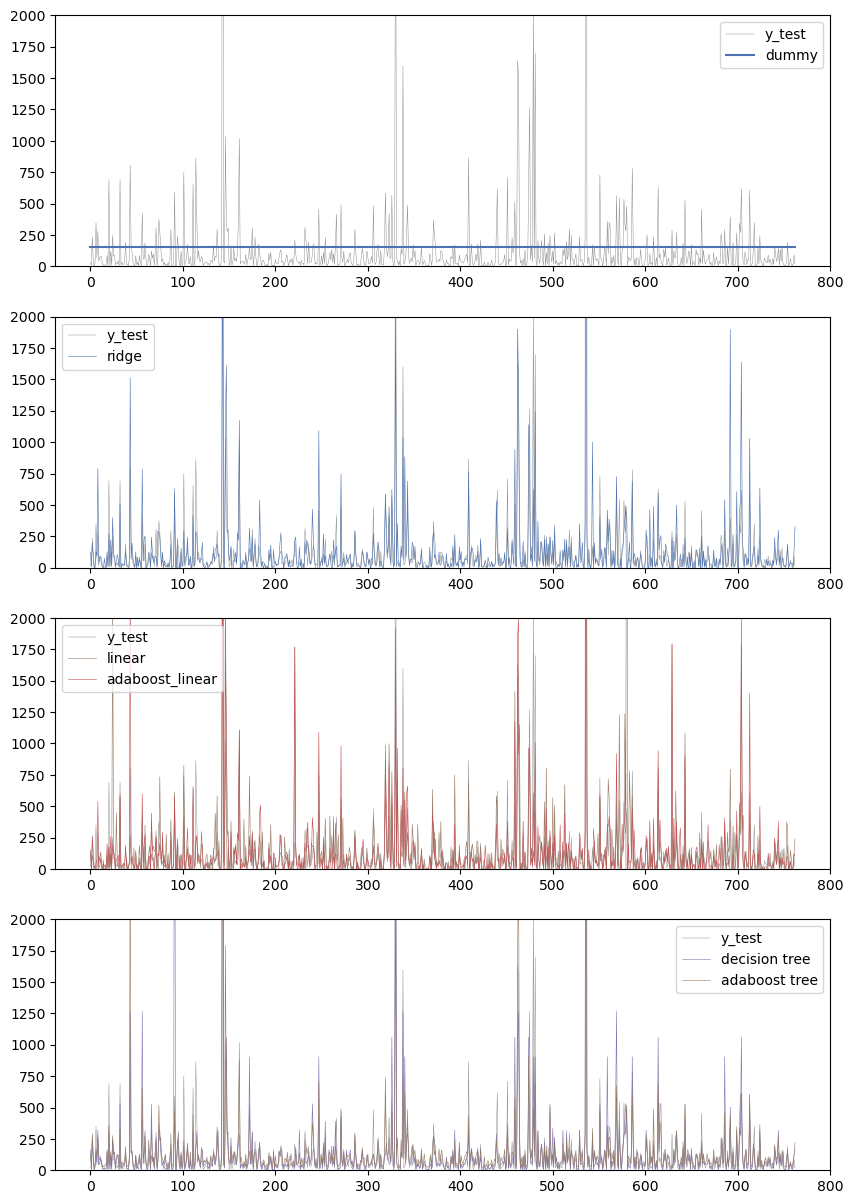

In [122]:
fig, ax = plt.subplots(4,1,figsize = (10,15))
sns.lineplot(x=pd.Series(y_test).index, y= y_test, color ='grey', label ='y_test',linewidth=0.3, ax =ax[0])
sns.lineplot(x=pd.Series(y_test).index, y= y_test, color ='grey', label ='y_test',linewidth=0.3, ax =ax[1])
sns.lineplot(x=pd.Series(y_test).index, y= y_test, color ='grey', label ='y_test',linewidth=0.3, ax =ax[2])
sns.lineplot(x=pd.Series(y_test).index, y= y_test, color ='grey', label ='y_test',linewidth=0.3, ax =ax[3])
sns.lineplot(x=pd.Series(y_test).index, y = y_pred_dummy, dashes = True,color = sns_c[0], label ='dummy', ax=ax[0])
sns.lineplot(x=pd.Series(y_test).index, y = y_pred_ridge, color = sns_c[0], label ='ridge',linewidth=0.4, ax=ax[1])
sns.lineplot(x=pd.Series(y_test).index, y = y_pred_linear, color = sns_c[5], label ='linear',linewidth=0.4, ax=ax[2])
sns.lineplot(x=pd.Series(y_test).index, y = y_pred_adaboost_linear, color = sns_c[3], label ='adaboost_linear',linewidth=0.4, ax=ax[2])
sns.lineplot(x=pd.Series(y_test).index, y = y_pred_tree, color = sns_c[4], label ='decision tree',linewidth=0.4, ax=ax[3])
sns.lineplot(x=pd.Series(y_test).index, y = y_pred_adaboost_tree, color = sns_c[5], label ='adaboost tree',linewidth=0.4, ax=ax[3])
for i in range(4):
    ax[i].set_ylim(0, 2000)

In [124]:
cond = df_summary['Modele'] == 'BaggingRegressor'
df_summary.iloc[[11,12,13],[0,1,3,4,5,6,7]]

,Modele,Ensembliste,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
11,GradientBoostingRegressor,DecisionTreeRegressor,25.84,276.45,1.00,0.77,
12,GradientBoostingRegressor,DecisionTreeRegressor,89.96,280.27,0.98,0.77,arrêt précoce
13,XGBRegressor,DecisionTreeRegressor,14.30,361.45,1.00,0.61,


## B - Consommation energetique

## 1.2 - Selection des variables 

In [125]:
target = df['SourceEUIWN(kBtu/sf)']

### Variables Explicatives

In [126]:
num_features = [
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'Electricity_p',
    'NaturalGaz_p',
    'Latitude',
    'Longitude',
    'NonResidentialGFA',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'NumberofBuildings',
    'NumberofFloors',
    'ratio_Site_Source_WN'
]

num_bin_features =  ['NumberofBuildings']

cat_features = [
    'PrimaryPropertyType',
    'BuildingType',
    'LargestPropertyUseType'
]

### 1.3.4 - Séparation de la base de donnée

In [127]:
#creation d'une colonne pour stratifier la séparation entre le jeu d'entrainement et de test
df['SourceEUIWN_qt'] = pd.qcut(df['SourceEUIWN(kBtu/sf)'],3)

In [128]:
#Séparation des observations entre train et test
X_train, X_test, y_train, y_test = train_test_split(df[num_features + cat_features],df['SourceEUIWN(kBtu/sf)'].values ,test_size =0.5, random_state =18,
                                     stratify = df['GHGEmissionsIntensity_qt'])

In [129]:
#Creation de la dataframe Summary
df_summary = pd.DataFrame(columns = ['Modele','Ensembliste','Target','Train_RMSE','Test_RMSE','Train_R2',
            'Test_R2', 'Commentaires'])
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires


# 2 - Les modeles

## 2.1 Les modeles simple

In [130]:
dummy_reg = Pipeline(
    [
        ("preprocessor", init_spo()),
        ("regressor", DummyRegressor(strategy="mean"))
    ]
)

In [131]:
dummy_reg_TE = clone(dummy_reg).fit(X_train, y_train)
df_summary =summary(dummy_reg_TE,df_summary, X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.0,-0.0,


### 2.2 - Ridge

In [132]:
ridge_reg = Pipeline(
    [
        ("preprocessor", init_spo()),
        ("regressor", Ridge())
    ]
)

In [133]:
ridge_reg_TE = ridge_reg.fit(X_train, y_train)
#parametrage
param_grid = {'regressor__alpha' : [0,1,10,100],
              'preprocessor__nun_t__poly__degree': [1,2,3]
             }
scoring = 'neg_mean_squared_error'
gs = GridSearchCV(
    ridge_reg_TE, param_grid,
    cv =10,
    scoring = scoring,
    n_jobs =-1,
    return_train_score = True, 
    error_score='raise').fit(X_train, y_train)

print(gs.best_params_)

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.91752e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


{'preprocessor__nun_t__poly__degree': 1, 'regressor__alpha': 10}


In [134]:
ridge_reg_TE.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(ridge_reg_TE,df_summary, X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.0,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.4,0.33,


### 2.1.2 - LinearRegression

In [135]:
lin_reg = Pipeline(
    [
        ("preprocessor", init_spo()),
        ("regressor", LinearRegression())
    ]
)

In [136]:
lin_reg_TE = lin_reg.fit(X_train, y_train)
#parametrage
scoring = 'neg_mean_squared_error'
params_grid = {'preprocessor__nun_t__poly__degree' : [1,2,3],
               'regressor__fit_intercept' : [True, False]}
gs = GridSearchCV(lin_reg_TE,
                  params_grid,
                  cv = 5,
                  scoring = scoring,
                  n_jobs = -1,
                  return_train_score = True
                 ).fit(X_train, y_train)

print(gs.best_params_)

{'preprocessor__nun_t__poly__degree': 1, 'regressor__fit_intercept': True}


In [137]:
lin_reg_TE.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(lin_reg_TE,df_summary, X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,


### 2.1.3 - DecisionTreeRegressor

In [138]:
tree_reg_TE = Pipeline(
    [
        ("preprocessor", init_o()),
        ("regressor", DecisionTreeRegressor())
    ]
)

In [139]:
#parametrage
param_grid = {'regressor__max_depth' : [5,8,15],
              'regressor__min_samples_leaf' : [10, 20,30],
             }
scoring = 'neg_mean_squared_error'
gs = GridSearchCV(tree_reg_TE,param_grid, cv=10, scoring = scoring,return_train_score = True,
                  verbose =-1, n_jobs =-1).fit(X_train, y_train)
print(gs.best_params_)

{'regressor__max_depth': 8, 'regressor__min_samples_leaf': 30}


In [140]:
tree_reg_TE.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(tree_reg_TE,df_summary, X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,
3,DecisionTreeRegressor,non,TotalGHGEmissions,133.29,151.04,0.26,0.11,


In [141]:
depth = tree_reg_TE[-1].get_depth()
n_leaves = tree_reg_TE[-1].get_n_leaves()
print(f"la profondeur de l'arbre est de {depth} et le nombre de feuilles (noeuds terminaux) est de {n_leaves}")

la profondeur de l'arbre est de 8 et le nombre de feuilles (noeuds terminaux) est de 23


### 2.1.4 -  Support Vector Machine SVM

In [142]:
svr_reg_TE = Pipeline(
    [
        ("preprocessor", init_so()),
        ("regressor", SVR())
    ]
)

In [143]:
param_grid = {'regressor__C' :[1, 10],
              'regressor__epsilon' : [1,110,200]
             }

scoring = 'neg_mean_squared_error'
gs = GridSearchCV(svr_reg_TE,param_grid, cv = 6, scoring =scoring,
                 verbose = -1, return_train_score = True, n_jobs =-1).fit(X_train, y_train)
print(gs.best_params_)

{'regressor__C': 10, 'regressor__epsilon': 110}


In [144]:
svr_reg_TE.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(svr_reg_TE,df_summary, X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,
3,DecisionTreeRegressor,non,TotalGHGEmissions,133.29,151.04,0.26,0.11,
4,SVR,non,TotalGHGEmissions,153.77,160.06,0.01,0.00,


## 2.2 - Modeled'ensemble

### 2.2.1 - bagging and pasting

### 2.2.1.1 - Bagging - Linear regression

In [145]:
estimator = LinearRegression()
bag_lin_reg = BaggingRegressor(estimator,bootstrap = True, n_jobs = -1)
modele =Pipeline(steps = [
    ('preprocessor', init_spo()),
    ('estimator', bag_lin_reg)
])

In [146]:
#parametrage
param_grid = {'estimator__n_estimators': [300,500],
              'estimator__max_samples' : [0.5,1]}
scoring = 'neg_mean_squared_error'
gs = GridSearchCV(modele,
                  param_grid,
                  cv = 6,
                  scoring= scoring,
                  return_train_score =True,
                  verbose = 1).fit(X_train, y_train)
print(gs.best_params_)

Fitting 6 folds for each of 4 candidates, totalling 24 fits
{'estimator__max_samples': 1, 'estimator__n_estimators': 500}


In [147]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test,ensembliste ='LinearRegression' )
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,
3,DecisionTreeRegressor,non,TotalGHGEmissions,133.29,151.04,0.26,0.11,
4,SVR,non,TotalGHGEmissions,153.77,160.06,0.01,0.00,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,154.83,160.39,-0.00,-0.00,


### 2.2.1.2 - Bagging - SVR

In [148]:
estimator = SVR()
bag_lin_reg = BaggingRegressor(estimator,bootstrap = True, n_jobs = -1)
modele =Pipeline(steps = [
    ('preprocessor', init_so()),
    ('estimator', bag_lin_reg)
])

In [149]:
modele[-1].get_params().keys()

dict_keys(['base_estimator__C', 'base_estimator__cache_size', 'base_estimator__coef0', 'base_estimator__degree', 'base_estimator__epsilon', 'base_estimator__gamma', 'base_estimator__kernel', 'base_estimator__max_iter', 'base_estimator__shrinking', 'base_estimator__tol', 'base_estimator__verbose', 'base_estimator', 'bootstrap', 'bootstrap_features', 'max_features', 'max_samples', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [150]:
#parametrage
param_grid = {'estimator__base_estimator__C' : [15000, 20000],
              'estimator__base_estimator__degree' : [1,2],
              'estimator__n_estimators' : [1000,1100]}

scoring = 'neg_mean_squared_error'
gs = GridSearchCV(modele,
                  param_grid,
                  cv = 3,
                  scoring=scoring,
                  n_jobs= -1,
                  verbose = 1).fit(X_train, y_train)
print(gs.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
{'estimator__base_estimator__C': 20000, 'estimator__base_estimator__degree': 2, 'estimator__n_estimators': 1100}


In [151]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "SVR")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,
3,DecisionTreeRegressor,non,TotalGHGEmissions,133.29,151.04,0.26,0.11,
4,SVR,non,TotalGHGEmissions,153.77,160.06,0.01,0.00,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,154.83,160.39,-0.00,-0.00,
6,BaggingRegressor,SVR,TotalGHGEmissions,146.96,174.64,0.10,-0.19,


### 2.2.1.3 Bagging - Decision Tree regressor

In [152]:
estimator = DecisionTreeRegressor()
bag_lin_reg = BaggingRegressor(estimator, n_estimators = 500, max_samples = 0.1, bootstrap = True, n_jobs = -1)
modele =Pipeline(steps = [
    ('preprocessor', init_o()),
    ('estimator', bag_lin_reg)
])

In [153]:
n_estimators = arret_precoce(modele,X_train,y_train,X_test,y_test, 500, 20)
n_estimators

n_estimators =29 et rmse =  135.13


29

In [154]:
modele.set_params(estimator__n_estimators =28).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "DecisionTreeRegressor",
                   commentaires = "avec arret précoce")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,
3,DecisionTreeRegressor,non,TotalGHGEmissions,133.29,151.04,0.26,0.11,
4,SVR,non,TotalGHGEmissions,153.77,160.06,0.01,0.00,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,154.83,160.39,-0.00,-0.00,
6,BaggingRegressor,SVR,TotalGHGEmissions,146.96,174.64,0.10,-0.19,
7,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,122.40,140.40,0.37,0.23,avec arret précoce


### 2.2.2 - Adaboost

### 2.2.2.1 - Linear Regresssion

In [155]:
predicteur = LinearRegression()
modele = Pipeline(steps = 
                   [
                       ('preprocessor', init_spo()),
                       ( 'estimateur',AdaBoostRegressor(predicteur, n_estimators =10,  learning_rate = 0.5))
                   ]
                  )

In [156]:
#parametrage
param_grid = {'estimateur__n_estimators' :[1,10,100],
              'preprocessor__nun_t__poly__degree' : [1,2,3],
              'estimateur__learning_rate' : [0.1,0.5,0.8]}
gs = GridSearchCV(modele,
                  param_grid, 
                  cv = 6,
                  return_train_score = True,
                  n_jobs = -1,
                  verbose = -1).fit(X_train, y_train)
print(gs.best_params_)

{'estimateur__learning_rate': 0.1, 'estimateur__n_estimators': 1, 'preprocessor__nun_t__poly__degree': 1}


In [157]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "LinearRegresssion")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,
3,DecisionTreeRegressor,non,TotalGHGEmissions,133.29,151.04,0.26,0.11,
4,SVR,non,TotalGHGEmissions,153.77,160.06,0.01,0.00,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,154.83,160.39,-0.00,-0.00,
6,BaggingRegressor,SVR,TotalGHGEmissions,146.96,174.64,0.10,-0.19,
7,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,122.40,140.40,0.37,0.23,avec arret précoce
8,AdaBoostRegressor,LinearRegresssion,TotalGHGEmissions,122.07,139.08,0.38,0.25,


### 2.2.2.4 - Adaboost avec un DecisionTreeRegressor

In [158]:
estimateur = DecisionTreeRegressor()
modele = Pipeline(steps = 
                   [
                       ('preprocessor', init_o()),
                       ( 'estimateur',AdaBoostRegressor(estimateur, n_estimators =10,  learning_rate = 0.5))
                   ]
                  )

In [159]:
#parametrage
param_grid = {'estimateur__n_estimators' :[100,120],
              'estimateur__learning_rate' : [0.8, 1],
              'estimateur__base_estimator__max_depth' : [10,15],
              'estimateur__base_estimator__min_samples_leaf' : [10,15],}
gs = GridSearchCV(modele,
                  param_grid, 
                  cv = 6,
                  return_train_score = True,
                  n_jobs = -1,
                  verbose = 1).fit(X_train, y_train)
print(gs.best_params_)

Fitting 6 folds for each of 16 candidates, totalling 96 fits
{'estimateur__base_estimator__max_depth': 15, 'estimateur__base_estimator__min_samples_leaf': 15, 'estimateur__learning_rate': 0.8, 'estimateur__n_estimators': 120}


In [160]:
modele.set_params(**gs.best_params_).fit(X_train, y_train)
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "DecisionTreeRegressor")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,
3,DecisionTreeRegressor,non,TotalGHGEmissions,133.29,151.04,0.26,0.11,
4,SVR,non,TotalGHGEmissions,153.77,160.06,0.01,0.00,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,154.83,160.39,-0.00,-0.00,
6,BaggingRegressor,SVR,TotalGHGEmissions,146.96,174.64,0.10,-0.19,
7,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,122.40,140.40,0.37,0.23,avec arret précoce
8,AdaBoostRegressor,LinearRegresssion,TotalGHGEmissions,122.07,139.08,0.38,0.25,
9,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,57.35,109.23,0.86,0.54,


In [161]:
### 2.2.4 - XGBoost (extreme Gradient Boosting)

In [162]:
import xgboost
xgboost.XGBRegressor().__init__

<bound method XGBRegressor.__init__ of XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)>

In [163]:
modele = Pipeline(steps = 
                   [
                       ('preprocessor', init_o()),
                       ( 'estimateur',xgboost.XGBRegressor())
                   ]
                  )

In [164]:
modele.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(sparse_threshold=0,
                                   transformers=[('passthrough_numeric',
                                                  'passthrough',
                                                  ['LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'Electricity_p',
                                                   'NaturalGaz_p', 'Latitude',
                                                   'Longitude',
                                                   'NonResidentialGFA',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'NumberofBuild...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [165]:
df_summary =summary(modele,df_summary, X_train, X_test, y_train, y_test, ensembliste = "DecisionTreeRegressor")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,154.78,160.48,0.00,-0.00,
1,Ridge,non,TotalGHGEmissions,120.16,131.75,0.40,0.33,
2,LinearRegression,non,TotalGHGEmissions,106.44,101.18,0.53,0.60,
3,DecisionTreeRegressor,non,TotalGHGEmissions,133.29,151.04,0.26,0.11,
4,SVR,non,TotalGHGEmissions,153.77,160.06,0.01,0.00,
5,BaggingRegressor,LinearRegression,TotalGHGEmissions,154.83,160.39,-0.00,-0.00,
6,BaggingRegressor,SVR,TotalGHGEmissions,146.96,174.64,0.10,-0.19,
7,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,122.40,140.40,0.37,0.23,avec arret précoce
8,AdaBoostRegressor,LinearRegresssion,TotalGHGEmissions,122.07,139.08,0.38,0.25,
9,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,57.35,109.23,0.86,0.54,


In [166]:
### Comparaison la distribution entre les observations et les predictions des differents models

NameError: name 'df_train' is not defined

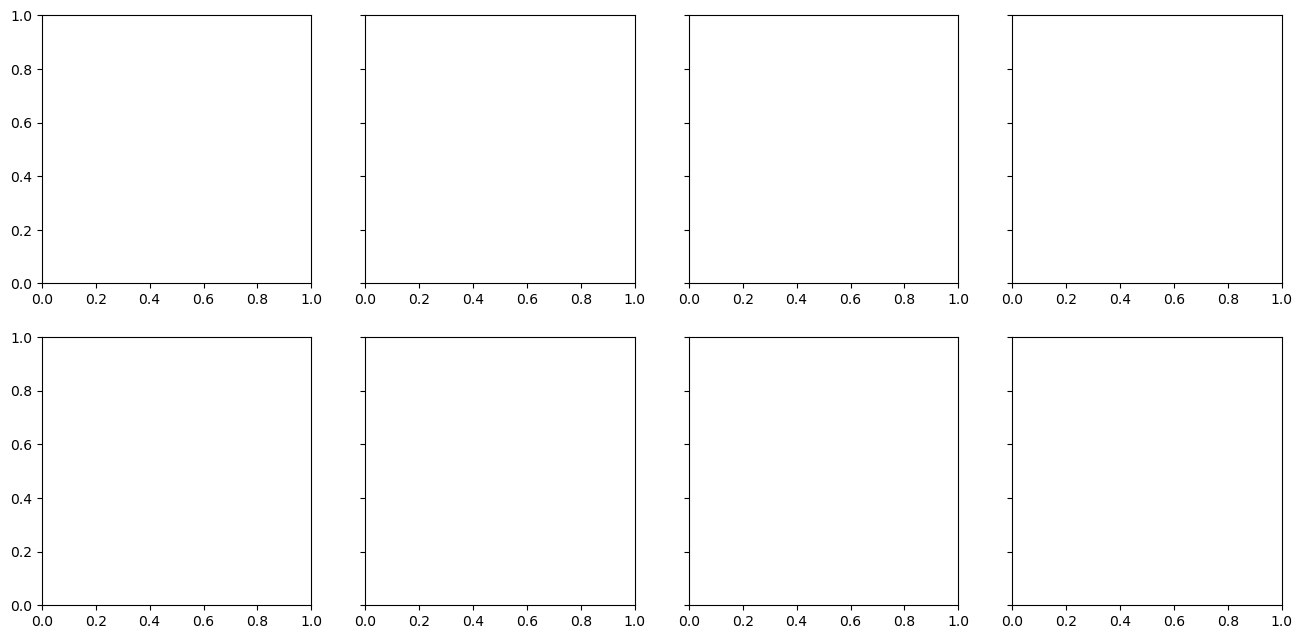

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.88327e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.94169e-25): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.29978e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.68746e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
/home/br

In [167]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (16,5), sharey = True)
fig.subplots_adjust(bottom =-0.3)
n_bins = 500

for row_idx, label, df in zip(range(2),["train","test"], [df_train, df_test]):
    sns.histplot(data = df['TotalGHGEmissions'], bins = n_bins, ax = axes[row_idx,0])
    axes[row_idx, 0].set_title('data')
    axes[row_idx, 0].set_ylabel(label)
    axes[row_idx, 0].set_xlim(-100,1500)
    axes[row_idx, 0].set_xlabel('y_oberved')
    
    for idx, model in enumerate([lin_reg, ridge_reg, tree_reg]):
        y_pred=model.predict(df)
        sns.histplot(pd.Series(y_pred), bins =n_bins, ax = axes[row_idx, idx+1])
        axes[row_idx,idx +1].set(
            title = model[-1].__class__.__name__,
            xlabel="y_pred (predicted expected Frequency)",
            xlim = (-100,1500)
        )

plt.show()